In [1]:
import networkx as nx

# Membuat graf terarah (directed graph)
G = nx.DiGraph()

# Baca file .txt
with open("amazon0302.txt", "r") as file:
    for line in file:
        if line.startswith("#"):  # Abaikan baris komentar
            continue
        source, target = map(int, line.strip().split())  # Pisahkan node asal dan tujuan
        G.add_edge(source, target)  # Tambahkan edge ke graf

print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")

Total Nodes: 262111
Total Edges: 1234877


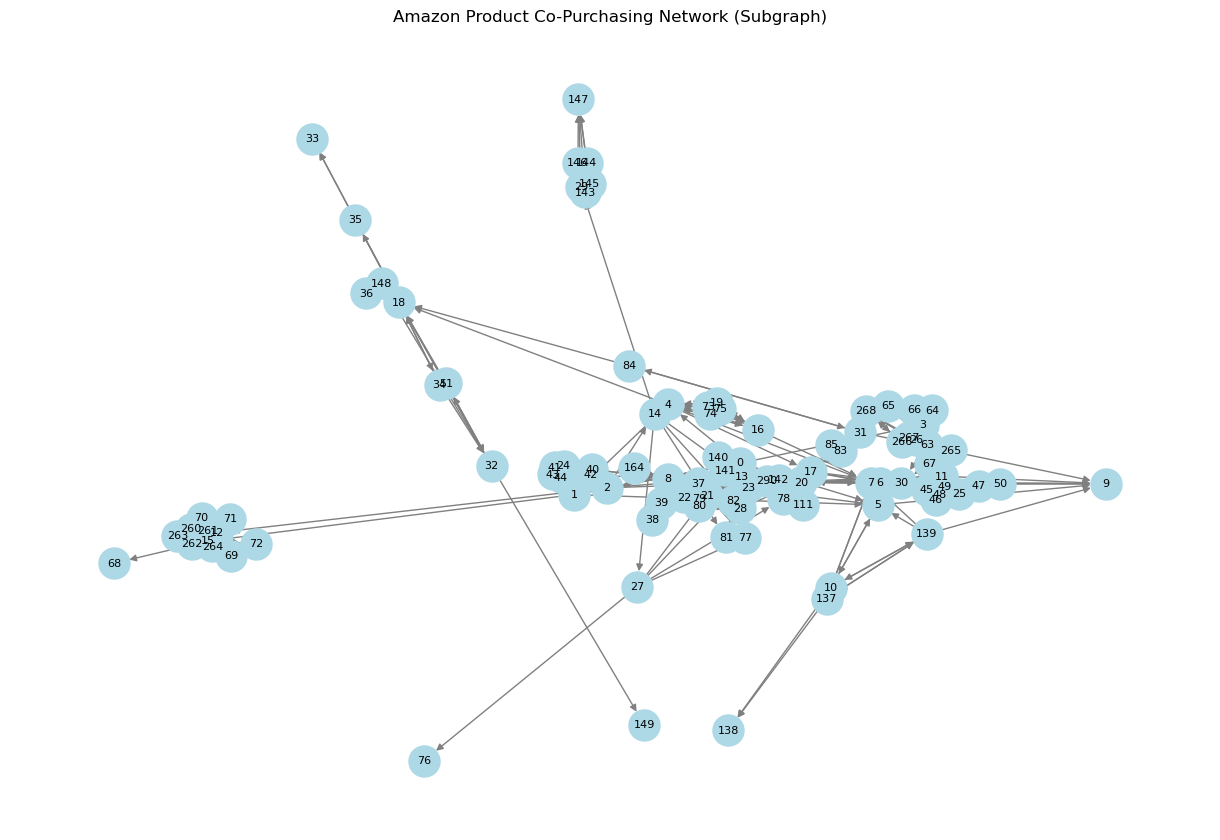

In [2]:
import matplotlib.pyplot as plt

# Ambil subgraf dari 100 node pertama untuk visualisasi
subgraph = G.subgraph(list(G.nodes)[:100])

plt.figure(figsize=(12, 8))
nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)
plt.title("Amazon Product Co-Purchasing Network (Subgraph)")
plt.show()

In [3]:
import networkx as nx
import networkx.algorithms.community as nx_comm



# Gunakan algoritma Louvain untuk menemukan komunitas dalam graf
communities = nx_comm.louvain_communities(G)

# Tampilkan jumlah komunitas yang ditemukan
print(f"Jumlah komunitas yang ditemukan: {len(communities)}")

# Tampilkan 5 komunitas pertama (hanya 10 produk pertama di setiap komunitas untuk efisiensi)
for i, community in enumerate(communities[:5]):
    print(f"Komunitas {i+1}: {list(community)[:10]}")


Jumlah komunitas yang ditemukan: 193
Komunitas 1: [86297, 7, 53263, 57364, 143381, 143382, 143383, 45077, 8212, 4123]
Komunitas 2: [253964, 253965, 253966, 73749, 16406, 16407, 73750, 73751, 73752, 16419]
Komunitas 3: [172033, 8195, 71643, 106512, 229393, 8216, 8217, 49194, 73786, 147526]
Komunitas 4: [204800, 204801, 212995, 212996, 212997, 15, 32785, 32786, 16403, 16404]
Komunitas 5: [40961, 40962, 40963, 45058, 45059, 40971, 13, 28689, 20, 21]


In [4]:
nx.write_graphml(G, "amazon0302.graphml")


Langkah 2: Perist ke ArangoDB

In [5]:
#Koneksi ke ArangoDB
#simpan dataset ke dalam database ArangoDB

In [ ]:
import os
from arango import ArangoClient
from dotenv import load_dotenv

# Load variabel dari file .env
load_dotenv()

# Ambil konfigurasi dari .env
ARANGO_HOST = os.getenv("ARANGO_HOST")
ARANGO_USERNAME = os.getenv("ARANGO_USERNAME")
ARANGO_PASSWORD = os.getenv("ARANGO_PASSWORD")
ARANGO_DB_NAME = os.getenv("ARANGO_DB_NAME")

# Inisialisasi klien ArangoDB
client = ArangoClient(hosts=ARANGO_HOST)

# Koneksi ke database
db = client.db(ARANGO_DB_NAME, username=ARANGO_USERNAME, password=ARANGO_PASSWORD)

# Cek apakah database aktif
if db.has_collection("products"):
    print("✅ Koneksi ke database berhasil!")
else:
    print("⚠️ Database tidak ditemukan!")


✅ Koneksi ke database berhasil!


Masukkan data ke arango db


In [32]:
# Pastikan koleksi untuk produk dan hubungan antar produk ada
if not db.has_collection("products"):
    db.create_collection("products")
    print("✅ Koleksi 'products' berhasil dibuat!")

if not db.has_collection("co_purchases"):
    db.create_collection("co_purchases", edge=True)
    print("✅ Koleksi 'co_purchases' (edges) berhasil dibuat!")


In [33]:
products_collection = db.collection("products")

# Tambahkan semua produk sebagai node di ArangoDB
for node in G.nodes():
    data = {"_key": str(node)}  # ArangoDB membutuhkan _key unik
    products_collection.insert(data, overwrite=True)

print("✅ Semua produk berhasil dimasukkan ke ArangoDB!")


KeyboardInterrupt: 

In [34]:
products_collection = db.collection("products")

# List semua produk dari G.nodes
products_list = [{"_key": str(node)} for node in G.nodes()]

# Bulk insert semua (overwrite true untuk update yang sama)
products_collection.insert_many(products_list, overwrite=True)

print(f"✅ {len(products_list)} produk berhasil diinsert ulang (bulk) ke ArangoDB!")


✅ 262111 produk berhasil diinsert ulang (bulk) ke ArangoDB!


In [37]:
db.collection("co_purchases").truncate()


True

In [41]:
if db.has_collection("co_purchases"):
    db.delete_collection("co_purchases")

db.create_collection("co_purchases", edge=True)


<StandardCollection co_purchases>

In [1]:
edges_collection = db.collection("co_purchases")

edges = [
    {
        "_from": f"products/{source}",
        "_to": f"products/{target}"
    }
    for source, target in G.edges()
]

edges_collection.insert_many(edges, overwrite=True)
print(f"✅ {len(edges)} hubungan antar produk berhasil dimasukkan ke ArangoDB!")


NameError: name 'db' is not defined

In [40]:
cursor = db.aql.execute("FOR e IN co_purchases LIMIT 5 RETURN e")
for doc in cursor:
    print(doc)


{'_key': '1451708', '_id': 'co_purchases/1451708', '_rev': '_jVuxX-q---'}
{'_key': '1451709', '_id': 'co_purchases/1451709', '_rev': '_jVuxX-q--_'}
{'_key': '1451710', '_id': 'co_purchases/1451710', '_rev': '_jVuxX-q--A'}
{'_key': '1451711', '_id': 'co_purchases/1451711', '_rev': '_jVuxX-q--B'}
{'_key': '1451712', '_id': 'co_purchases/1451712', '_rev': '_jVuxX-q--C'}


In [ ]:
# edges_collection = db.collection("co_purchases")

# # Tambahkan semua hubungan antar produk
# for edge in G.edges():
#     data = {
#         "_from": f"products/{edge[0]}",
#         "_to": f"products/{edge[1]}"
#     }
#     edges_collection.insert(data, overwrite=True)

# print("✅ Semua hubungan antar produk berhasil dimasukkan ke ArangoDB!")


Langkah 3: Buat Agent untuk Query Natural Language

In [ ]:
import google.generativeai as genai

# Konfigurasi Gemini AI dengan API Key dari .env
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)

# Inisialisasi model Gemini
model = genai.GenerativeModel("gemini-1.5-pro-latest")


In [ ]:
def query_graph_gemini(user_query):
    # Gunakan Gemini AI untuk memahami pertanyaan
    response = model.generate_content(user_query)
    
    # Ambil teks hasil query
    query_result = response.text

    return query_result


In [ ]:
query = "Produk apa yang paling sering dibeli bersama dengan produk 123?"
response = query_graph_gemini(query)
print(response)


Saya tidak memiliki akses ke data penjualan atau inventaris tertentu yang sebenarnya. Oleh karena itu, saya tidak dapat memberi tahu Anda produk apa yang paling sering dibeli bersama dengan "produk 123".

Untuk mendapatkan informasi ini, Anda perlu mengakses data dari sistem point of sale atau database analisis perusahaan yang menjual produk 123. Anda bisa mencoba menghubungi perusahaan tersebut atau tim analis mereka untuk meminta data tersebut.

Jika "produk 123" merujuk pada produk spesifik di platform tertentu (misalnya, toko online), Anda bisa mencari informasi tentang "frequently bought together", "customers also bought", atau rekomendasi produk serupa di halaman produk tersebut.



In [ ]:
# models = genai.list_models()
# for model in models:
#     print(model.name)


Test with ArangoDB to answer question

In [ ]:
# Cek semua koleksi yang ada di database
collections = db.collections()
for col in collections:
    print(col["name"])


_aqlfunctions
_apps
products
_analyzers
_jobs
_frontend
_graphs
_appbundles
_queues


In [ ]:
if not db.has_collection("co_purchases"):
    db.create_collection("co_purchases")
    print("✅ Koleksi 'co_purchases' berhasil dibuat!")


✅ Koleksi 'co_purchases' berhasil dibuat!


In [ ]:
cursor = db.aql.execute("FOR doc IN co_purchases RETURN doc")
data = list(cursor)

if not data:
    print("⚠️ Koleksi 'co_purchases' kosong. Silakan tambahkan data terlebih dahulu.")
else:
    print("✅ Data ditemukan di koleksi 'co_purchases'!")


⚠️ Koleksi 'co_purchases' kosong. Silakan tambahkan data terlebih dahulu.


In [ ]:
def get_co_purchased_products(product_id):
    query = """
    FOR p IN co_purchases
        FILTER p._from == @product_id
        RETURN p._to
    """
    cursor = db.aql.execute(query, bind_vars={"product_id": f"products/{product_id}"})
    return list(cursor)


In [ ]:
products_bought_together = get_co_purchased_products(123)
print(f"Produk yang sering dibeli bersama produk 123: {products_bought_together}")


AQLQueryExecuteError: [HTTP 404][ERR 1203] collection or view not found: co_purchases

In [ ]:
# Cek semua koleksi yang ada di database
collections = db.collections()
for col in collections:
    print(col["name"])


_aqlfunctions
_apps
products
_analyzers
_jobs
_frontend
_graphs
_appbundles
_queues


In [ ]:
cursor = db.aql.execute("FOR doc IN products LIMIT 5 RETURN doc")
for doc in cursor:
    print(doc)


In [ ]:
graph_names = db.graphs()
print("Graph yang tersedia:", graph_names)


Graph yang tersedia: []
